In [29]:
# Autoencoder.ipynb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [2]:
# CUDA setting
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA GPU : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')

CUDA GPU : NVIDIA GeForce RTX 4070 Ti SUPER


In [136]:
# Dataset download (MNIST)

BATCH_SIZE = 512

train_data = datasets.MNIST('./1. Autoencoder/data', train=True, download=True, transform=transforms.ToTensor())
test_data =  datasets.MNIST('./1. Autoencoder/data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader =  torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [126]:
# Model implement : Autoencoder
# Input tensor : (batch_size, 1, 28, 28) & Output : (batch_size)

# Architecture : 1x28x28 -> (filtersize:4, stride:2, padding:0 ) -> 1x13x13 -> 1x28x28

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 1x28x28 -> 32x14x14
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # 32x14x14 -> 64x7x7
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # 64x7x7 -> 64x1x1
            nn.ReLU(),
        )

        self.latent_encoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=2, bias=True),
            nn.ReLU()
        )
        
        self.latent_decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=64, bias=True),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        # x = x.reshape(-1, 1, 64)
        # x = self.latent_encoder(x)

        # x = self.latent_decoder(x)
        # x = x.reshape(-1, 64, 1, 1)
        x = self.decoder(x)

        return x

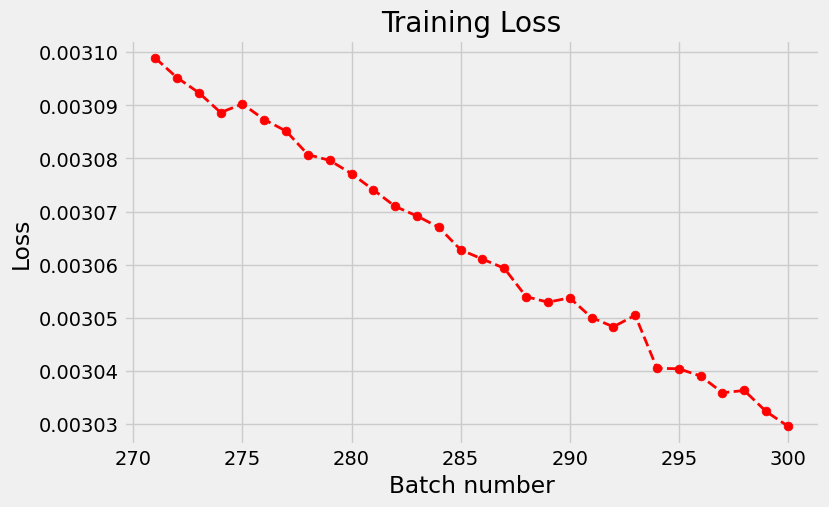

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [03:18<00:00,  1.51it/s]


In [127]:
# Model Training
from IPython import display

model = Autoencoder().to(device)

epoch = 300

learning_rate = 2E-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

losses = []

for epoch_idx in trange(epoch):
    model.train()

    running_loss = 0.0
    total_batches = 0

    for (x_train, _) in train_loader:
        x_train = x_train.to(device)
        output = model(x_train)
        
        loss = loss_fn(x_train, output)
        running_loss += loss.item()
        total_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(running_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        yrange = losses[xrange[0]-1:xrange[-1]]
    else:
        yrange = losses[:]
    
    plt.plot(xrange,yrange, linestyle='--', linewidth=2, c='r')
    plt.scatter(xrange, yrange, c='red', s=40)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


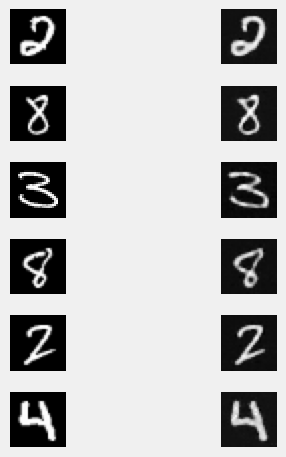

In [131]:
import matplotlib.pyplot as plt

start_idx = 400
num_pairs = 6

for i in range(num_pairs):
    # Original Image
    plt.subplot(num_pairs, 2, 2*i+1)
    data = test_data[start_idx + i][0]
    img = data.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(num_pairs, 2, 2*i+2)
    with torch.no_grad():
        reconstructed_images = model(data.to(device))
    reconstructed_images = reconstructed_images.cpu()
    plt.imshow(reconstructed_images.reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [135]:
# torch.save(model, "./Autoencoder_MNIST.pt")
torch.load("./1. Autoencoder/Autoencoder_MNIST.pt") # Why not ./Autoencoder_MNIST.pt??

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
  )
  (latent_encoder): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): ReLU()
  )
  (latent_decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)